In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

desktop_path = Path('.')

# Define evaluation metrics functions
def calculate_rmse_and_qlike(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    predictions = np.clip(predictions, 1e-8, None)
    rmse = np.sqrt(np.mean(np.square(predictions - actuals)))
    qlike = np.mean(actuals / predictions - np.log(actuals / predictions) - 1)
    return rmse, qlike

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if len(y_true) == 0:
        return np.nan
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmpse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if len(y_true) == 0:
        return np.nan
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

def evaluate_predictions(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    if len(predictions) != len(actuals):
        raise ValueError("Prediction and actual arrays must have the same length")
    
    mask = ~(np.isnan(predictions) | np.isnan(actuals))
    if not np.any(mask):
        return np.nan, np.nan, np.nan, np.nan
    clean_predictions = predictions[mask]
    clean_actuals = actuals[mask]
    
    upper_bound = np.percentile(clean_actuals, 99.9)
    lower_bound = np.percentile(clean_actuals, 0.1)
    valid_data = (clean_actuals >= lower_bound) & (clean_actuals <= upper_bound)
    clean_predictions = clean_predictions[valid_data]
    clean_actuals = clean_actuals[valid_data]
    
    if len(clean_predictions) == 0:
        return np.nan, np.nan, np.nan, np.nan
    
    rmse, qlike = calculate_rmse_and_qlike(clean_predictions, clean_actuals)
    mape = calculate_mape(clean_actuals, clean_predictions)
    rmpse = calculate_rmpse(clean_actuals, clean_predictions)
    return rmse, qlike, mape, rmpse

# Load and evaluate models
model_names = ['LAG', 'HAR_RV', 'Linear', 'PCA_Linear', 'Random_Forest', 'Gradient_Boosting', 'GAT']
model_predictions = {}

for model in model_names:
    filename = f"{model}_prediction_panel.csv" if model == 'GAT' else f"{model}_predictions.csv"
    try:
        data = pd.read_csv(desktop_path / filename, index_col=0)
        for column in data.columns:
            data[column] = pd.to_numeric(data[column], errors='coerce')
        model_predictions[model] = data
    except:
        continue

actual_volatility = pd.read_csv(desktop_path / "real_volatility.csv", index_col=0)
for column in actual_volatility.columns:
    actual_volatility[column] = pd.to_numeric(actual_volatility[column], errors='coerce')

# Find common data and evaluate
shared_dates = None
shared_stocks = None
for model, data in model_predictions.items():
    if shared_dates is None:
        shared_dates = data.index
        shared_stocks = data.columns
    else:
        shared_dates = shared_dates.intersection(data.index)
        shared_stocks = shared_stocks.intersection(data.columns)

aligned_actuals = actual_volatility.loc[shared_dates, shared_stocks]
results_summary = []

for model, data in model_predictions.items():
    try:
        aligned_predictions = data.loc[shared_dates, shared_stocks]
        all_predictions = aligned_predictions.values.flatten()
        all_actuals = aligned_actuals.values.flatten()
        valid_data = ~(np.isnan(all_predictions) | np.isnan(all_actuals))
        clean_predictions = all_predictions[valid_data]
        clean_actuals = all_actuals[valid_data]
        
        if len(clean_predictions) >= 10:
            rmse, qlike, mape, rmpse = evaluate_predictions(clean_predictions, clean_actuals)
        else:
            rmse, qlike, mape, rmpse = np.nan, np.nan, np.nan, np.nan
        
        results_summary.append({
            'Model': model,
            'RMSE': rmse,
            'QLIKE': qlike,
            'MAPE': mape,
            'RMPSE': rmpse
        })
    except:
        results_summary.append({
            'Model': model,
            'RMSE': np.nan,
            'QLIKE': np.nan,
            'MAPE': np.nan,
            'RMPSE': np.nan
        })

# Create ranking table
summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.round({'RMSE': 6, 'QLIKE': 6, 'MAPE': 2, 'RMPSE': 2})

print("Model rankings (sorted by RMSE):")
print("="*80)
rankings = summary_df.sort_values('RMSE').reset_index(drop=True)
rankings.index = rankings.index + 1
print(rankings[['Model', 'RMSE', 'QLIKE', 'MAPE', 'RMPSE']].to_string())

Model rankings (sorted by RMSE):
               Model      RMSE      QLIKE    MAPE   RMPSE
1                GAT  0.001252  44.277583   45.52   67.94
2             HAR_RV  0.001735   0.145669   46.48   60.37
3         PCA_Linear  0.001739   0.147543   45.39   59.27
4             Linear  0.001750   0.148681   52.13   68.20
5                LAG  0.001966   0.191350   83.72  109.24
6      Random_Forest  0.002880   0.260178  121.31  182.02
7  Gradient_Boosting  0.004830   0.373931  199.88  351.96


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

desktop_path = Path('.')

# Define evaluation metrics functions
def calculate_rmse_and_qlike(predictions, actuals):
    """Calculate Root Mean Square Error and Quasi-Likelihood metrics"""
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    predictions = np.clip(predictions, 1e-8, None)  # Avoid division by zero
    rmse = np.sqrt(np.mean(np.square(predictions - actuals)))
    qlike = np.mean(actuals / predictions - np.log(actuals / predictions) - 1)
    return rmse, qlike

def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = (y_true != 0)  # Exclude zero values to avoid division by zero
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if len(y_true) == 0:
        return np.nan
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmpse(y_true, y_pred):
    """Calculate Root Mean Percentage Square Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = (y_true != 0)  # Exclude zero values
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if len(y_true) == 0:
        return np.nan
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

def evaluate_predictions(predictions, actuals):
    """Main evaluation function with data cleaning and outlier removal"""
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    if len(predictions) != len(actuals):
        raise ValueError("Prediction and actual arrays must have the same length")
    
    # Remove NaN values
    mask = ~(np.isnan(predictions) | np.isnan(actuals))
    if not np.any(mask):
        return np.nan, np.nan, np.nan, np.nan
    clean_predictions = predictions[mask]
    clean_actuals = actuals[mask]
    
    # Remove outliers using percentile bounds
    upper_bound = np.percentile(clean_actuals, 99.9)
    lower_bound = np.percentile(clean_actuals, 0.1)
    valid_data = (clean_actuals >= lower_bound) & (clean_actuals <= upper_bound)
    clean_predictions = clean_predictions[valid_data]
    clean_actuals = clean_actuals[valid_data]
    
    if len(clean_predictions) == 0:
        return np.nan, np.nan, np.nan, np.nan
    
    # Calculate all metrics
    rmse, qlike = calculate_rmse_and_qlike(clean_predictions, clean_actuals)
    mape = calculate_mape(clean_actuals, clean_predictions)
    rmpse = calculate_rmpse(clean_actuals, clean_predictions)
    return rmse, qlike, mape, rmpse

# Load model predictions
print("Loading model predictions...")
model_names = ['LAG', 'HAR_RV', 'Linear', 'PCA_Linear', 'Random_Forest', 'Gradient_Boosting', 'GAT']
model_predictions = {}

for model in model_names:
    # Handle different filename for GAT model
    filename = f"{model}_prediction_panel.csv" if model == 'GAT' else f"{model}_predictions.csv"
    try:
        data = pd.read_csv(desktop_path / filename, index_col=0)
        # Try to parse dates
        try:
            data.index = pd.to_datetime(data.index)
        except ValueError:
            print(f"Note: Unable to parse dates for {model}, keeping original index")
        # Convert to numeric
        for column in data.columns:
            data[column] = pd.to_numeric(data[column], errors='coerce')
        model_predictions[model] = data
        print(f"Loaded {model} successfully - Shape: {data.shape}")
    except FileNotFoundError:
        print(f"Warning: Could not find file {filename}")
    except Exception as error:
        print(f"Error loading {model}: {str(error)}")

# Load actual volatility data
print("\nLoading actual volatility data...")
try:
    actual_volatility = pd.read_csv(desktop_path / "real_volatility.csv", index_col=0)
    try:
        actual_volatility.index = pd.to_datetime(actual_volatility.index)
    except ValueError:
        print("Note: Unable to parse dates for actual values, keeping original index")
    # Convert to numeric
    for column in actual_volatility.columns:
        actual_volatility[column] = pd.to_numeric(actual_volatility[column], errors='coerce')
    print(f"Loaded actual volatility - Shape: {actual_volatility.shape}")
except FileNotFoundError:
    print("Error: Could not find 'real_volatility.csv' file")
    exit(1)
except Exception as error:
    print(f"Error loading actual volatility: {str(error)}")
    exit(1)

# Find common dates and stocks across all models
shared_dates = None
shared_stocks = None
for model, data in model_predictions.items():
    if shared_dates is None:
        shared_dates = data.index
        shared_stocks = data.columns
    else:
        shared_dates = shared_dates.intersection(data.index)
        shared_stocks = shared_stocks.intersection(data.columns)

print(f"Common data points: {len(shared_dates)} dates × {len(shared_stocks)} stocks")

# Align actual data with common dates and stocks
try:
    aligned_actuals = actual_volatility.loc[shared_dates, shared_stocks]
    print(f"Aligned actual values shape: {aligned_actuals.shape}")
except KeyError:
    print("Warning: Alignment issue detected, attempting flexible matching")
    shared_dates = shared_dates.intersection(actual_volatility.index)
    shared_stocks = [stock for stock in shared_stocks if stock in actual_volatility.columns]
    aligned_actuals = actual_volatility.loc[shared_dates, shared_stocks]
    print(f"Re-aligned actual values shape: {aligned_actuals.shape}")

# Evaluate each model
results_summary = []
detailed_metrics = {}

for model, data in model_predictions.items():
    print(f"\nEvaluating {model} model...")
    try:
        # Align predictions with common dates and stocks
        aligned_predictions = data.loc[shared_dates, shared_stocks]
        
        # Flatten arrays for overall evaluation
        all_predictions = aligned_predictions.values.flatten()
        all_actuals = aligned_actuals.values.flatten()
        
        # Remove NaN values
        valid_data = ~(np.isnan(all_predictions) | np.isnan(all_actuals))
        clean_predictions = all_predictions[valid_data]
        clean_actuals = all_actuals[valid_data]
        
        # Overall model evaluation
        if len(clean_predictions) < 10:
            print(f"Warning: Insufficient data for {model} ({len(clean_predictions)} points)")
            rmse, qlike, mape, rmpse = np.nan, np.nan, np.nan, np.nan
        else:
            rmse, qlike, mape, rmpse = evaluate_predictions(clean_predictions, clean_actuals)
            print(f"  RMSE: {rmse:.6f}")
            print(f"  QLIKE: {qlike:.6f}")
            print(f"  MAPE: {mape:.2f}%")
            print(f"  RMPSE: {rmpse:.2f}%")
        
        # Store overall results
        results_summary.append({
            'Model': model,
            'RMSE': rmse,
            'QLIKE': qlike,
            'MAPE': mape,
            'RMPSE': rmpse,
            'Sample_Size': len(clean_predictions)
        })
        
        # Stock-by-stock evaluation
        stock_performance = {}
        for stock in shared_stocks:
            stock_pred = aligned_predictions[stock].values
            stock_actual = aligned_actuals[stock].values
            valid_mask = ~(np.isnan(stock_pred) | np.isnan(stock_actual))
            if sum(valid_mask) < 10:  # Skip stocks with insufficient data
                continue
            clean_stock_pred = stock_pred[valid_mask]
            clean_stock_actual = stock_actual[valid_mask]
            stock_rmse, stock_qlike, stock_mape, stock_rmpse = evaluate_predictions(clean_stock_pred, clean_stock_actual)
            stock_performance[stock] = {
                'RMSE': stock_rmse,
                'QLIKE': stock_qlike,
                'MAPE': stock_mape,
                'RMPSE': stock_rmpse
            }
        
        # Store detailed results
        detailed_metrics[model] = {
            'overall': {'RMSE': rmse, 'QLIKE': qlike, 'MAPE': mape, 'RMPSE': rmpse},
            'by_stock': stock_performance
        }
        
    except Exception as error:
        print(f"Error evaluating {model}: {str(error)}")
        results_summary.append({
            'Model': model,
            'RMSE': np.nan,
            'QLIKE': np.nan,
            'MAPE': np.nan,
            'RMPSE': np.nan,
            'Sample_Size': 0
        })

# Create and save summary DataFrame
summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.round({'RMSE': 6, 'QLIKE': 6, 'MAPE': 2, 'RMPSE': 2})

try:
    summary_df.to_csv(desktop_path / "model_metrics_summary_all.csv", index=False)
    print("\nMetrics summary saved to 'model_metrics_summary_all.csv'")
except Exception as error:
    print(f"Error saving summary: {str(error)}")

# Display overall results
print("\nModel Performance Summary:")
print("="*80)
print(summary_df.to_string(index=False))

# Find best performing model for each stock
top_performers = {}
for stock in shared_stocks:
    lowest_rmse = float('inf')
    best_performer = None
    for model in detailed_metrics:
        if stock in detailed_metrics[model]['by_stock']:
            rmse_value = detailed_metrics[model]['by_stock'][stock]['RMSE']
            if not np.isnan(rmse_value) and rmse_value < lowest_rmse:
                lowest_rmse = rmse_value
                best_performer = model
    if best_performer:
        top_performers[stock] = {'model': best_performer, 'RMSE': lowest_rmse}

# Display best performers by stock
print("\nBest performing model for each stock:")
print("="*80)
top_performers_df = pd.DataFrame.from_dict(top_performers, orient='index')
print(top_performers_df.to_string())

# Display model rankings
print("\nModel rankings (sorted by RMSE):")
print("="*80)
rankings = summary_df.sort_values('RMSE').reset_index(drop=True)
rankings.index = rankings.index + 1
print(rankings[['Model', 'RMSE', 'QLIKE', 'MAPE', 'RMPSE']].to_string())

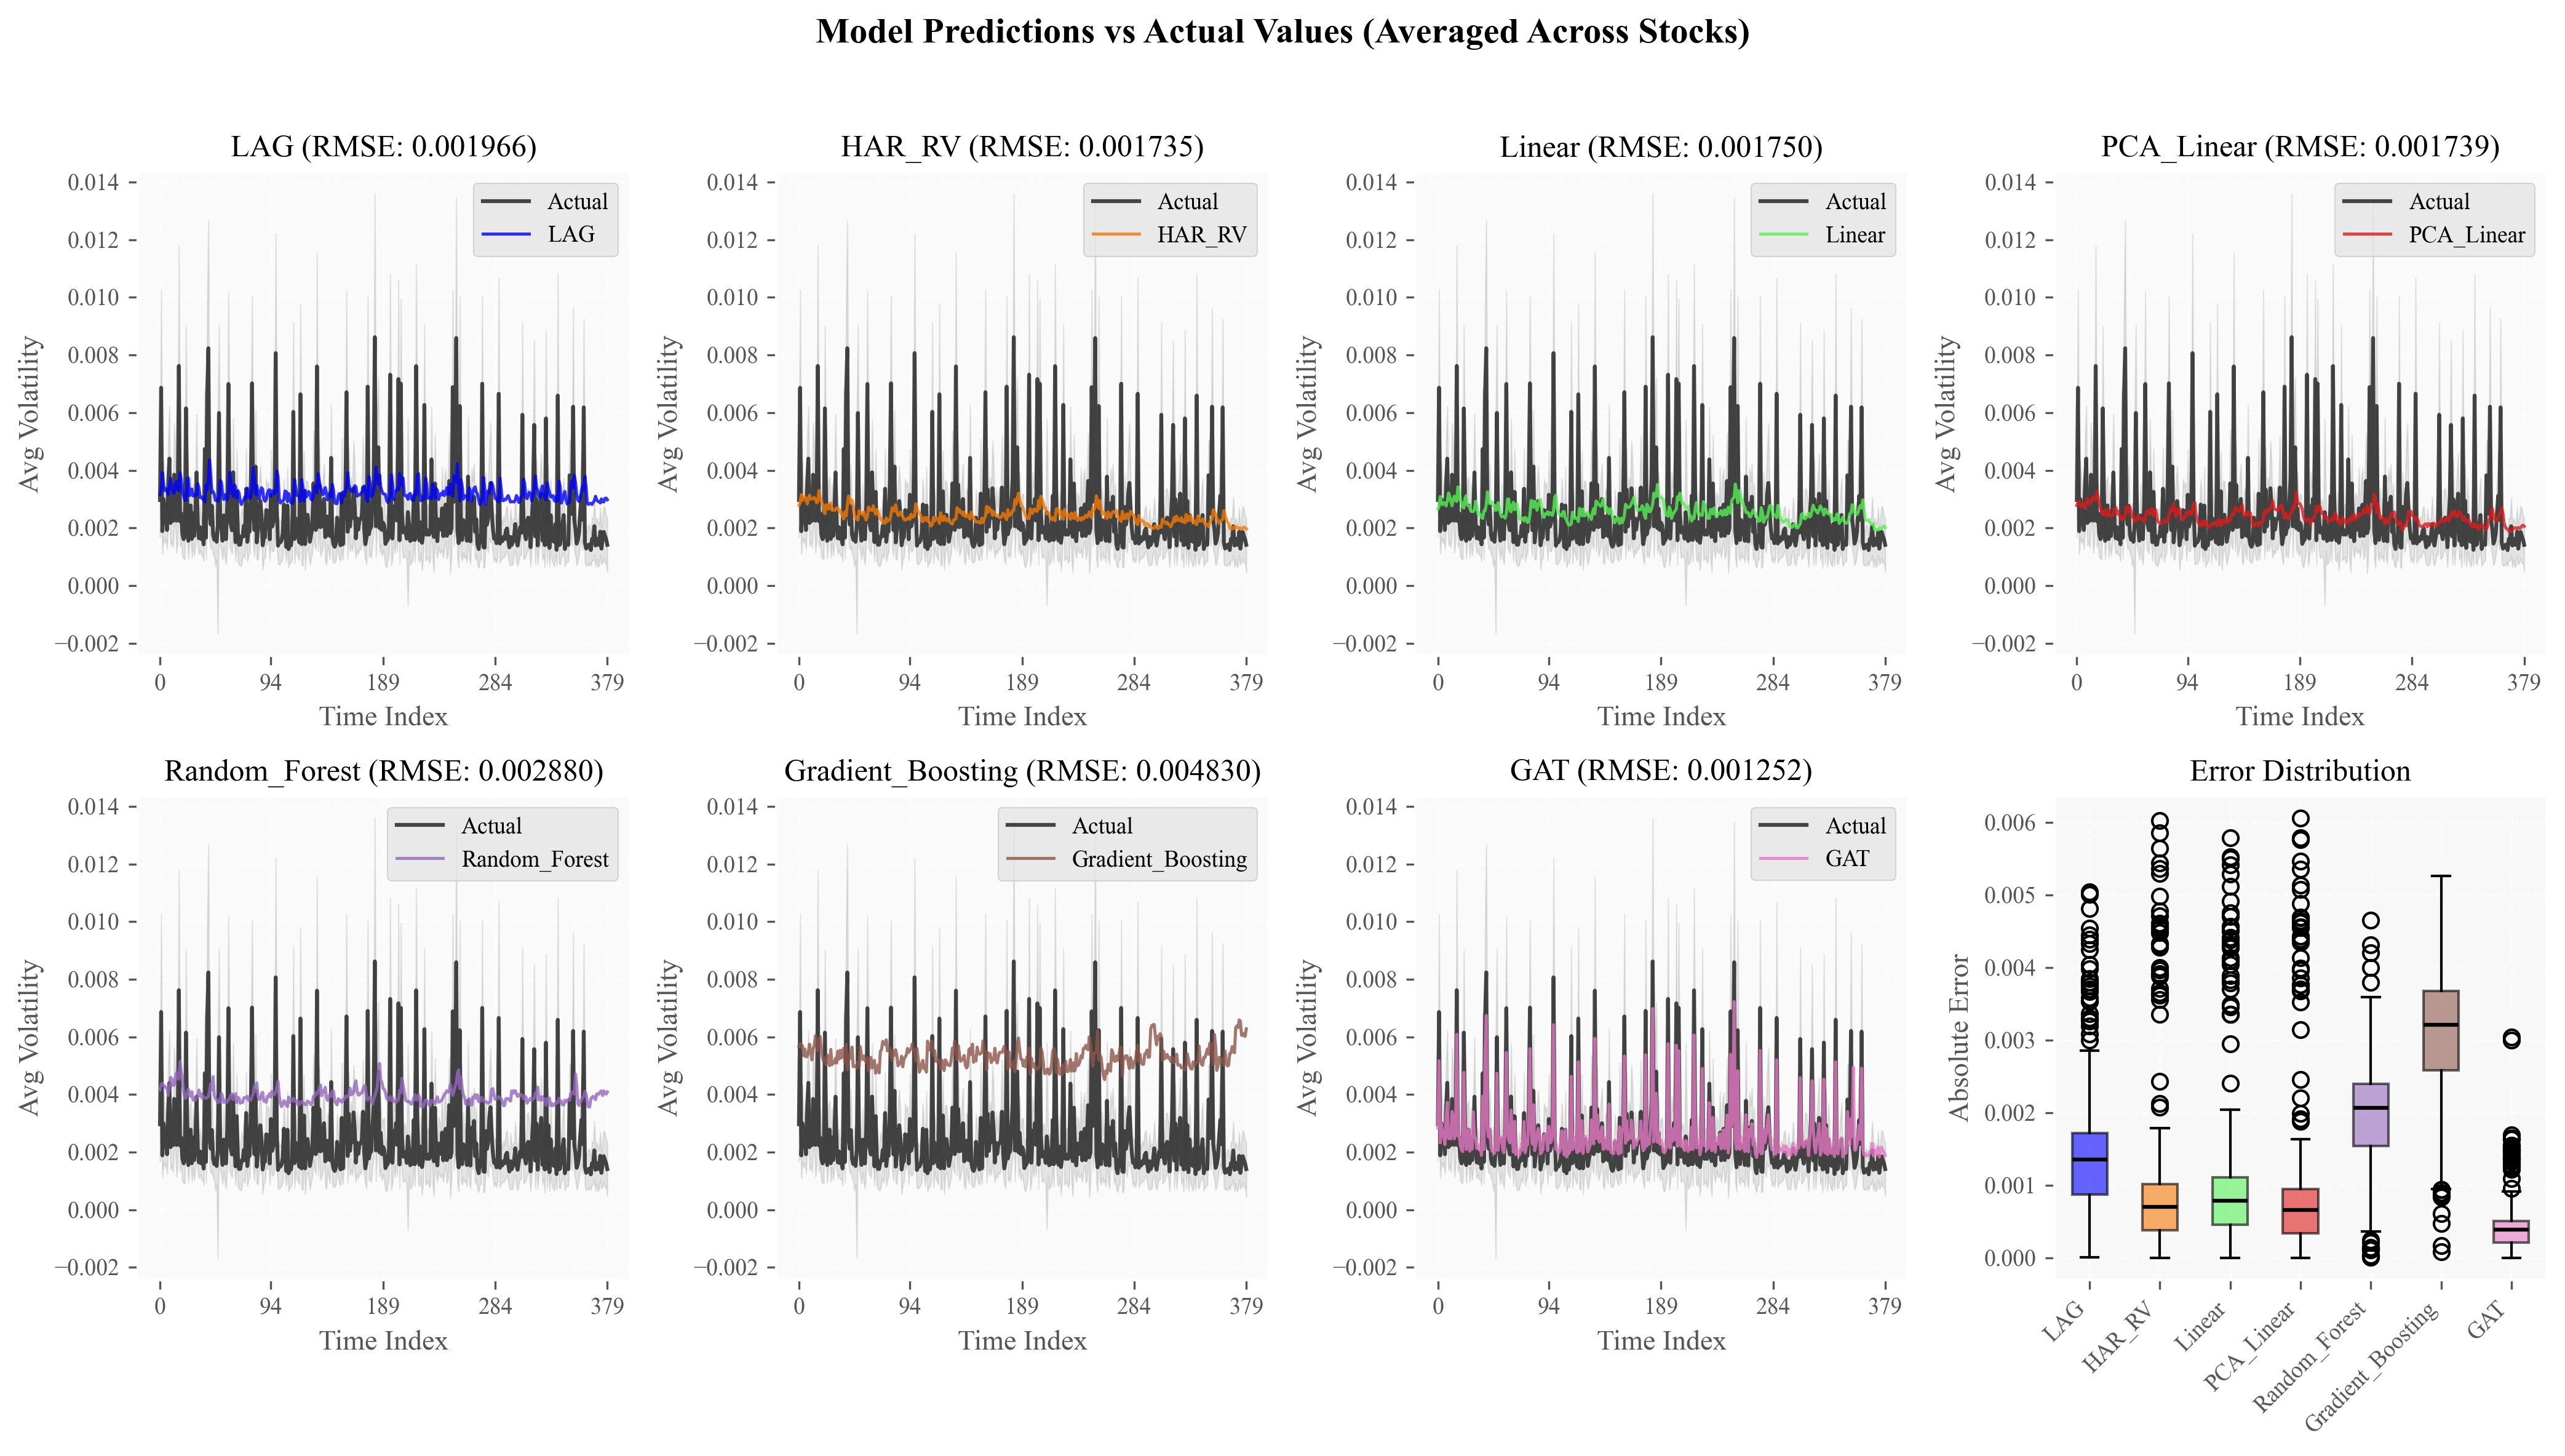

Plot saved as 'average_model_comparisons.png'


In [9]:
import matplotlib.pyplot as plt

def create_model_plots():
    """
    Create plots comparing each model's predictions with actual values
    using average volatility across all stocks.
    """
    # Basic plot style setup
    plt.style.use('ggplot')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.figsize': (14, 8),
        'figure.dpi': 300
    })
    
    # Colors for different data series
    colors = {
        'actual': '#1A1A1A',
        'model': ['#0000FF', "#F37805", "#56F056", "#DF1A1A", '#9467BD', '#8C564B', '#E377C2', '#FFFF00']
    }
    
    if len(shared_stocks) > 0:
        # Create subplot grid
        fig, axes = plt.subplots(2, 4, figsize=(14, 8))
        axes = axes.flatten()
        
        # Get average actual values
        avg_actual_values = aligned_actuals.mean(axis=1).values
        x_indices = np.arange(len(avg_actual_values))
        
        # For storing error data
        model_errors = {}
        
        for idx, (model_name, data) in enumerate(model_predictions.items()):
            if idx >= len(axes) - 1:  # Last position for boxplot
                break
                
            try:
                # Get average predictions for this model
                aligned_model_data = data.loc[shared_dates, shared_stocks]
                avg_model_pred = aligned_model_data.mean(axis=1).values
                
                # Calculate errors
                valid_mask = ~(np.isnan(avg_model_pred) | np.isnan(avg_actual_values))
                if np.sum(valid_mask) > 0:
                    errors = np.abs(avg_model_pred[valid_mask] - avg_actual_values[valid_mask])
                    model_errors[model_name] = errors
                
                # Plot the data
                axes[idx].plot(x_indices, avg_actual_values, '-', color=colors['actual'], 
                              linewidth=1.5, label='Actual', alpha=0.8)
                axes[idx].plot(x_indices, avg_model_pred, '-', color=colors['model'][idx % len(colors['model'])], 
                              linewidth=1.2, label=model_name, alpha=0.8)
                
                # Add title with RMSE
                rmse = detailed_metrics[model_name]['overall']['RMSE']
                axes[idx].set_title(f'{model_name} (RMSE: {rmse:.6f})')
                axes[idx].set_xlabel('Time Index')
                axes[idx].set_ylabel('Avg Volatility')
                axes[idx].legend(loc='upper right')
                
                # Add uncertainty range
                std_actual = aligned_actuals.std(axis=1).values
                axes[idx].fill_between(x_indices, 
                                      avg_actual_values - std_actual, 
                                      avg_actual_values + std_actual, 
                                      color=colors['actual'], alpha=0.1)
                
                # Style adjustments
                axes[idx].grid(True, linestyle='--', alpha=0.6)
                axes[idx].set_xticks(np.linspace(0, len(x_indices)-1, 5, dtype=int))
                axes[idx].set_facecolor("#FAFAFA")
                
            except Exception as e:
                axes[idx].text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
                              transform=axes[idx].transAxes, ha='center', va='center')
                axes[idx].set_title(f'{model_name} - Error')
        
        # Create boxplot of errors
        if model_errors:
            boxplot_data = [errors for model, errors in model_errors.items()]
            boxplot_labels = list(model_errors.keys())
            
            boxplot = axes[-1].boxplot(boxplot_data, patch_artist=True, vert=True)
            
            # Color the boxes
            for i, box in enumerate(boxplot['boxes']):
                box_color = colors['model'][i % len(colors['model'])]
                box.set(facecolor=box_color, alpha=0.6)
                boxplot['medians'][i].set(color='black', linewidth=1.5)
            
            axes[-1].set_title('Error Distribution')
            axes[-1].set_ylabel('Absolute Error')
            axes[-1].set_xticklabels(boxplot_labels, rotation=45, ha='right')
            axes[-1].grid(True, linestyle='--', alpha=0.6)
            axes[-1].set_facecolor('#F8F8F8')
        
        # Add title and adjust layout
        plt.suptitle('Model Predictions vs Actual Values (Averaged Across Stocks)', 
                    fontsize=14, y=0.98, fontweight='bold')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(desktop_path / "average_model_comparisons.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Plot saved as 'average_model_comparisons.png'")
    else:
        print("No shared stocks available for plotting.")

# Run the plotting function
create_model_plots()

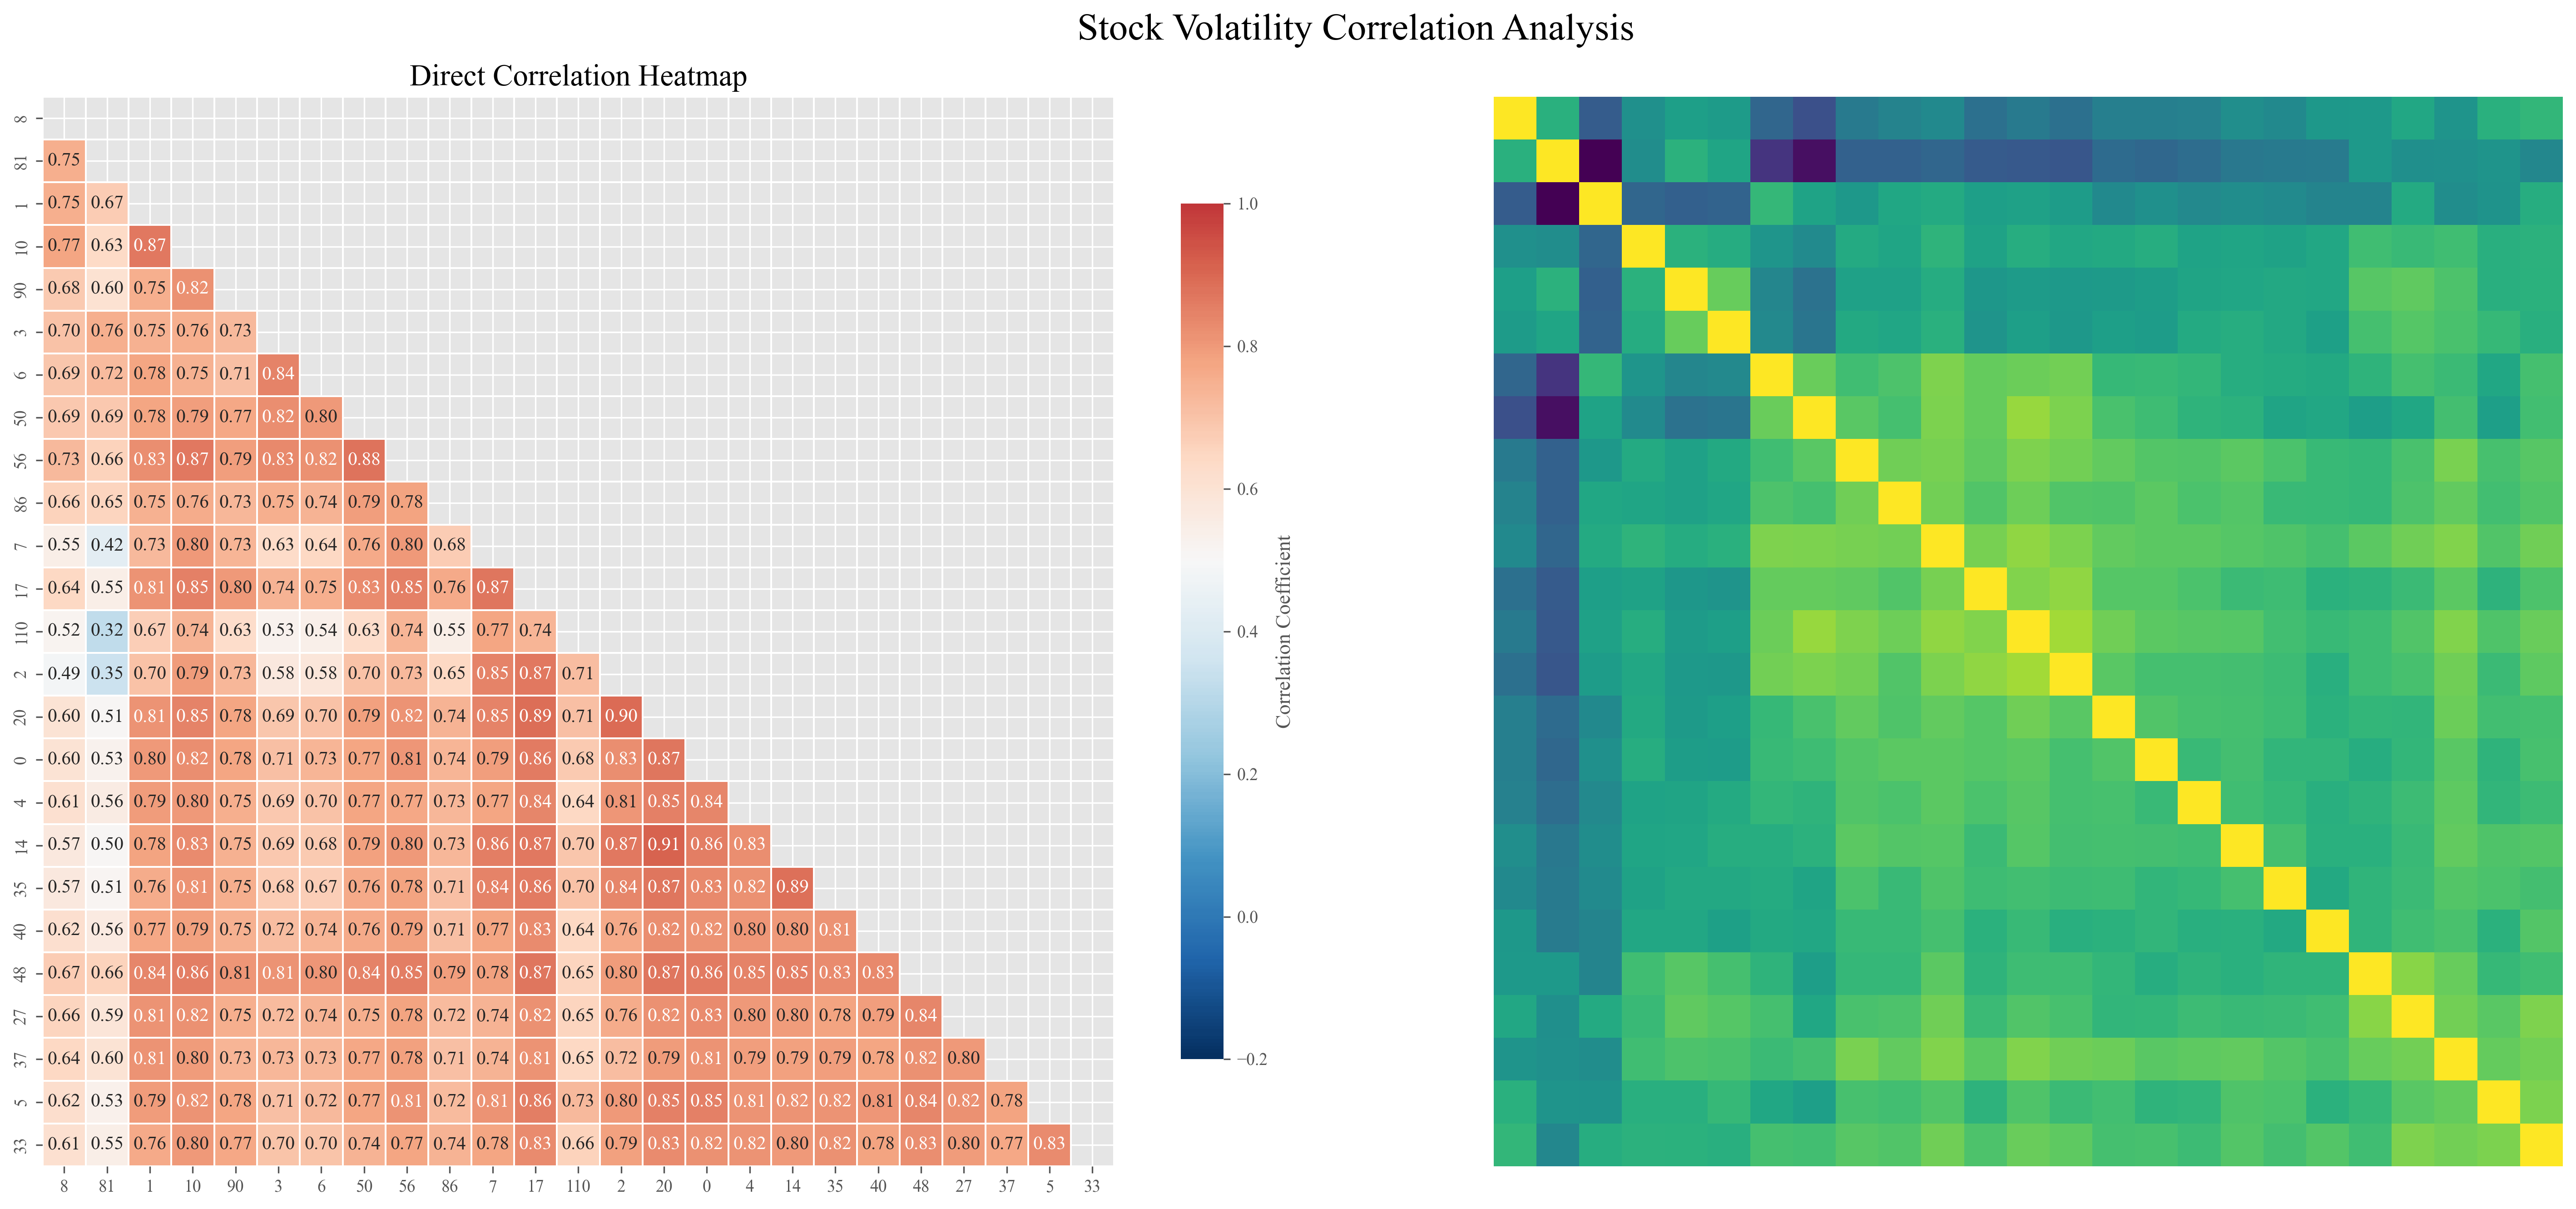

Correlation Statistics:
Average correlation: 0.8022
Median correlation: 0.8158
Maximum correlation: 0.9470
Minimum correlation: 0.2857

Top 10 most correlated stock pairs:
1. 69 and 29: 0.9470
2. 43 and 29: 0.9423
3. 119 and 14: 0.9332
4. 125 and 93: 0.9272
5. 93 and 67: 0.9254
6. 125 and 47: 0.9239
7. 73 and 56: 0.9238
8. 125 and 41: 0.9238
9. 125 and 14: 0.9234
10. 113 and 29: 0.9226

Top 10 least correlated stock pairs:
1. 81 and 43: 0.2857
2. 110 and 81: 0.3210
3. 81 and 2: 0.3485
4. 81 and 39: 0.4112
5. 81 and 34: 0.4207
6. 103 and 81: 0.4242
7. 81 and 7: 0.4242
8. 81 and 68: 0.4316
9. 125 and 81: 0.4447
10. 43 and 8: 0.4518


In [10]:
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance
import matplotlib.pyplot as plt
import numpy as np

# Create a correlation heatmap of stock volatilities
def visualize_stock_correlation():
    # Extract the volatility data for shared stocks
    volatility_data = actual_volatility.loc[:, shared_stocks]
    
    # Calculate the correlation matrix
    correlation_matrix = volatility_data.corr()
    
    # Convert correlation matrix to distance matrix
    dist = distance.squareform(1 - correlation_matrix.abs())
    
    # Perform hierarchical clustering
    linkage = hierarchy.linkage(dist, method='ward')
    
    # Get the indices for clustering
    clusters = hierarchy.fcluster(linkage, 15, criterion='maxclust')
    
    # Select representative stocks from each cluster
    selected_stocks = []
    for cluster_id in range(1, max(clusters)+1):
        cluster_stocks = [stock for i, stock in enumerate(correlation_matrix.index) if clusters[i] == cluster_id]
        # Take up to 2 stocks from each cluster
        selected_stocks.extend(cluster_stocks[:min(2, len(cluster_stocks))])
    
    # If we have too many or too few, adjust
    if len(selected_stocks) > 30:
        selected_stocks = selected_stocks[:30]
    elif len(selected_stocks) < 20:
        # Add more stocks if needed
        remaining = [s for s in correlation_matrix.index if s not in selected_stocks]
        selected_stocks.extend(remaining[:min(30-len(selected_stocks), len(remaining))])
    
    # Get the subset correlation matrix
    subset_corr = correlation_matrix.loc[selected_stocks, selected_stocks]
    
    # Create two visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # 1. Heatmap with dendrograms for clustering
    g = sns.clustermap(
        subset_corr, 
        cmap='RdBu_r',
        vmin=-0.2, 
        vmax=1.0,
        center=0.5,
        figsize=(10, 9),
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}
    )
    
    plt.close()  # Close the automatic figure
    
    # 2. Network plot for high correlations
    # Convert the correlation matrix to a more network-friendly format
    # Only keep correlations above threshold
    threshold = 0.7
    high_corr = subset_corr.copy()
    high_corr[high_corr < threshold] = 0
    
    # Basic network visualization in ax2
    mask = np.triu(np.ones_like(subset_corr, dtype=bool))
    sns.heatmap(
        subset_corr, 
        ax=ax1,
        cmap='RdBu_r',
        vmin=-0.2, 
        vmax=1.0,
        center=0.5,
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        mask=mask,
        cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}
    )
    ax1.set_title('Stock Volatility Correlation Heatmap (Subset)', fontsize=16)
    
    # Add the clustermap to the second axis
    ax2.imshow(g.data2d)
    ax2.axis('off')
    fig.add_axes(ax2)
    
    # Add the cluster map as the second visualization
    fig.suptitle('Stock Volatility Correlation Analysis', fontsize=20)
    ax1.set_title('Direct Correlation Heatmap', fontsize=16)
    
    plt.tight_layout()
    plt.savefig(desktop_path / "volatility_correlation_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate and display some statistics about the correlations
    flat_corr = correlation_matrix.values[np.tril_indices_from(correlation_matrix.values, k=-1)]
    avg_corr = np.mean(flat_corr)
    median_corr = np.median(flat_corr)
    max_corr = np.max(flat_corr)
    min_corr = np.min(flat_corr)
    
    print(f"Correlation Statistics:")
    print(f"Average correlation: {avg_corr:.4f}")
    print(f"Median correlation: {median_corr:.4f}")
    print(f"Maximum correlation: {max_corr:.4f}")
    print(f"Minimum correlation: {min_corr:.4f}")
    
    # Find most correlated pairs
    np.fill_diagonal(correlation_matrix.values, 0)  # Remove self-correlations
    top_n = 10
    
    # Get top correlations
    top_pairs = []
    for i in range(len(correlation_matrix)):
        for j in range(i):
            top_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
    
    top_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"\nTop {top_n} most correlated stock pairs:")
    for i, (stock1, stock2, corr) in enumerate(top_pairs[:top_n]):
        print(f"{i+1}. {stock1} and {stock2}: {corr:.4f}")
    
    print(f"\nTop {top_n} least correlated stock pairs:")
    for i, (stock1, stock2, corr) in enumerate(reversed(top_pairs[-top_n:])):
        print(f"{i+1}. {stock1} and {stock2}: {corr:.4f}")

# Run 
visualize_stock_correlation()